In [2]:
from dbConn import engine
import pandas as pd
import numpy as np
from tqdm import tqdm

In [3]:
base_query = '''
SELECT 
    spx.Datetime,
    spx.Open AS Open_SPX,
    spx.High AS High_SPX,
    spx.Low AS Low_SPX,
    spx.Close AS Close_SPX,
    ndx.Open AS Open_NDX,
    ndx.High AS High_NDX,
    ndx.Low AS Low_NDX,
    ndx.Close AS Close_NDX,
    rut.Open AS Open_RUT,
    rut.High AS High_RUT,
    rut.Low AS Low_RUT,
    rut.Close AS Close_RUT
    FROM (
    SELECT * FROM SPX_full_5min
    ) spx
    JOIN (
    SELECT * FROM NDX_full_5min
    ) ndx ON spx.Datetime = ndx.Datetime
    JOIN (
    SELECT * FROM RUT_full_5min
    ) rut ON spx.Datetime = rut.Datetime
-- WHERE spx.Datetime >= '2018-01-01'
'''

# Initialize variables for pagination
offset = 0
limit = 50000
data_frames = []

while True:
    # Construct the query with LIMIT and OFFSET
    query = f"{base_query} LIMIT {limit} OFFSET {offset}"
    
    # Fetch the chunk of data
    df_chunk = pd.read_sql_query(query, con = engine.connect())
    
    # Break the loop if no more data is returned
    if df_chunk.empty:
        break

    # Append the chunk to the list of dataframes
    data_frames.append(df_chunk)

    # Update the offset for the next query
    offset += limit

# Concatenate all dataframes
data = pd.concat(data_frames, ignore_index=True)

In [4]:
len(data)

330450

In [5]:
data.head()

,Datetime,Open_SPX,High_SPX,Low_SPX,Close_SPX,Open_NDX,High_NDX,Low_NDX,Close_NDX,Open_RUT,High_RUT,Low_RUT,Close_RUT
0,2007-04-27 12:20:00,1492.19,1492.40,1492.19,1492.38,1887.90,1887.91,1886.97,1887.65,829.54,829.55,829.35,829.41
1,2007-04-27 12:25:00,1492.39,1492.91,1492.39,1492.87,1887.72,1888.32,1887.72,1888.27,829.42,829.68,829.42,829.68
2,2007-04-27 12:30:00,1492.54,1492.80,1492.53,1492.58,1887.77,1888.68,1887.65,1888.13,829.65,829.84,829.65,829.73
3,2007-04-27 12:35:00,1492.70,1492.88,1492.30,1492.88,1888.09,1888.24,1887.27,1888.24,829.65,829.65,829.25,829.38
4,2007-04-27 12:40:00,1492.88,1494.46,1492.88,1493.94,1888.26,1890.01,1888.26,1889.31,829.39,830.08,829.39,830.03


In [6]:
data['Date'] = data['Datetime'].dt.date
data['Time'] = data['Datetime'].dt.time

In [7]:
import datetime

# Start Run Models

In [149]:
ticker_dict = {
    "^GSPC":{
        "hod_model":"models/hod_model_spx.joblib",
        "lod_model":"models/lod_model_spx.joblib",
        "gd_model":"models/gd_model_spx.joblib",
        "suffix":"SPX"
    },
    "^NDX":{
        "hod_model":"models/hod_model_ndx.joblib",
        "lod_model":"models/lod_model_ndx.joblib",
        "gd_model":"models/gd_model_ndx.joblib",
        "suffix":"NDX"
    },
    "^RUT":{
        "hod_model":"models/hod_model_rut.joblib",
        "lod_model":"models/lod_model_rut.joblib",
        "gd_model":"models/gd_model_rut.joblib",
        "suffix":"RUT"
    }
}

tck = '^GSPC'

spx_data = data.loc[:,[
    'Datetime',
    f'Open_{ticker_dict[tck]["suffix"]}',
    f'High_{ticker_dict[tck]["suffix"]}',
    f'Low_{ticker_dict[tck]["suffix"]}',
    f'Close_{ticker_dict[tck]["suffix"]}'
]]
spx_data.columns = ['Datetime','open','high','low','close']
spx_data['time'] = spx_data['Datetime'].dt.time
spx_data = spx_data.loc[(spx_data['time'] < datetime.time(16,0)) & (spx_data['time'] >= datetime.time(9,30))]

In [150]:
spx_data = spx_data.set_index('Datetime')

In [151]:
# Create a list of times from 9:30 to 15:55 with 5 minute intervals
times = pd.date_range(start="9:30", end="15:55", freq='5min').time

# Create a dictionary that maps each time to a unique integer
time_to_int = {time: i+1 for i, time in enumerate(times)}

# Assume df is your DataFrame and 'time' is your column of times
spx_data['bar_num'] = spx_data['time'].map(time_to_int)

In [152]:
# Get the last bar of each date
spx_data['eod_close'] = spx_data.groupby(spx_data.index.date)['close'].tail(1)
spx_data['prev_close'] = spx_data['eod_close'].shift(1)
spx_data['prev_close'] = spx_data['prev_close'].ffill()
spx_data['eod_close'] = spx_data['eod_close'].bfill()
spx_data['green_day'] = spx_data['eod_close'] > spx_data['prev_close']

spx_data['eod_close_pts'] = spx_data['eod_close'] - spx_data['prev_close']
spx_data['eod_close_pct'] = spx_data['eod_close_pts'] / spx_data['prev_close']

In [153]:
spx_data.head()

,open,high,low,close,time,bar_num,eod_close,prev_close,green_day,eod_close_pts,eod_close_pct
Datetime,,,,,,,,,,,
2007-04-27 12:20:00,1492.19,1492.40,1492.19,1492.38,12:20:00,35,1494.24,NaN,False,NaN,NaN
2007-04-27 12:25:00,1492.39,1492.91,1492.39,1492.87,12:25:00,36,1494.24,NaN,False,NaN,NaN
2007-04-27 12:30:00,1492.54,1492.80,1492.53,1492.58,12:30:00,37,1494.24,NaN,False,NaN,NaN
2007-04-27 12:35:00,1492.70,1492.88,1492.30,1492.88,12:35:00,38,1494.24,NaN,False,NaN,NaN
2007-04-27 12:40:00,1492.88,1494.46,1492.88,1493.94,12:40:00,39,1494.24,NaN,False,NaN,NaN


In [154]:
spx_data.tail()

,open,high,low,close,time,bar_num,eod_close,prev_close,green_day,eod_close_pts,eod_close_pct
Datetime,,,,,,,,,,,
2023-12-29 15:35:00,4773.29,4774.59,4773.25,4774.08,15:35:00,74,4772.17,4784.12,False,-11.95,-0.002498
2023-12-29 15:40:00,4774.07,4775.66,4771.86,4771.86,15:40:00,75,4772.17,4784.12,False,-11.95,-0.002498
2023-12-29 15:45:00,4771.78,4772.96,4770.34,4770.34,15:45:00,76,4772.17,4784.12,False,-11.95,-0.002498
2023-12-29 15:50:00,4770.31,4774.07,4765.37,4765.45,15:50:00,77,4772.17,4784.12,False,-11.95,-0.002498
2023-12-29 15:55:00,4765.57,4774.03,4763.58,4772.17,15:55:00,78,4772.17,4784.12,False,-11.95,-0.002498


# Feature and Target Creation
Target
- Whether the current high or low of the **session** has been achieved, based on the close of the most recent 5 min bar. 

Features
- Current and lagged features of each **session**.

In [155]:
import numpy as np
import pandas as pd
import datetime
from pandas.tseries.offsets import BDay
from tqdm import tqdm

spx_data['label'] = np.nan

# Per date, run it.
for day in tqdm(sorted(set(spx_data.index.date))):
    day_str = datetime.datetime.strftime(day, '%Y-%m-%d')
    day_open = spx_data.loc[day_str, 'open'].iloc[0]
    spx_data.loc[day_str, 'lod'] = spx_data.loc[day_str, 'low'].min()
    spx_data.loc[day_str, 'label_lod'] = (spx_data.loc[day_str, 'low'] == spx_data.loc[day_str, 'lod']).astype(int)
    
    spx_data.loc[day_str, 'hod'] = spx_data.loc[day_str, 'high'].max()
    spx_data.loc[day_str, 'label'] = (spx_data.loc[day_str, 'high'] == spx_data.loc[day_str, 'hod']).astype(int)
    spx_data.loc[day_str, 'day_open'] = day_open
    spx_data.loc[day_str, 'day_open_pts'] = spx_data.loc[day_str, 'close'] - spx_data.loc[day_str, 'day_open']
    spx_data.loc[day_str, 'day_open_pct'] = spx_data.loc[day_str, 'day_open_pts'] / spx_data.loc[day_str, 'day_open']
    spx_data.loc[day_str, 'prev_close_pts'] = spx_data.loc[day_str, 'close'] - spx_data.loc[day_str, 'prev_close']
    spx_data.loc[day_str, 'prev_close_pct'] = spx_data.loc[day_str, 'prev_close_pts'] / spx_data.loc[day_str, 'prev_close']

    # Lowest low
    spx_data.loc[day_str, 'lowest_low'] = spx_data.loc[day_str, 'low'].expanding().min()
    spx_data.loc[day_str, 'lowest_low'] = spx_data.loc[day_str, 'lowest_low'].shift(1)
    spx_data.loc[day_str, 'lowest_low'] = spx_data.loc[day_str, 'lowest_low'].ffill()
    spx_data.loc[day_str, 'lowest_low_mag'] = (spx_data.loc[day_str, 'close'] / spx_data.loc[day_str, 'lowest_low']) - 1

    # Highest high
    spx_data.loc[day_str, 'highest_high'] = spx_data.loc[day_str, 'high'].expanding().max()
    spx_data.loc[day_str, 'highest_high'] = spx_data.loc[day_str, 'highest_high'].shift(1)
    spx_data.loc[day_str, 'highest_high'] = spx_data.loc[day_str, 'highest_high'].ffill()
    spx_data.loc[day_str, 'highest_high_mag'] = (spx_data.loc[day_str, 'close'] / spx_data.loc[day_str, 'highest_high']) - 1

    # Shifted
    spx_data.loc[day_str, 'prev_close_pct_n1'] = spx_data.loc[day_str, 'prev_close_pct'].shift(1)
    spx_data.loc[day_str, 'prev_close_pct_n2'] = spx_data.loc[day_str, 'prev_close_pct'].shift(2)
    spx_data.loc[day_str, 'prev_close_pct_n3'] = spx_data.loc[day_str, 'prev_close_pct'].shift(3)

    spx_data.loc[day_str, 'day_open_pct_n1'] = spx_data.loc[day_str, 'day_open_pct'].shift(1)
    spx_data.loc[day_str, 'day_open_pct_n2'] = spx_data.loc[day_str, 'day_open_pct'].shift(2)
    spx_data.loc[day_str, 'day_open_pct_n3'] = spx_data.loc[day_str, 'day_open_pct'].shift(3)

    # New Features
    spx_data.loc[day_str, 'open_slope'] = spx_data.loc[day_str, 'day_open_pct'] / spx_data.loc[day_str, 'bar_num']
    spx_data.loc[day_str, 'daily_slope'] = spx_data.loc[day_str, 'prev_close_pct'] / spx_data.loc[day_str, 'bar_num']


    # Label the data: 1 if the current high is the HOD, 0 otherwise

    # # Find the index of HOD
    # hod_index = spx_data.loc[day_str][spx_data.loc[day_str, 'label'] == 1].index

    # # If HOD is found within the first 5 bars, label the first 5 bars as 1
    # if not hod_index.empty:
    #     hod_index = hod_index[0]  # In case there are multiple, take the first
    #     if hod_index <= spx_data.loc[day_str].index[4]:  # Check if HOD is within the first 5 bars
    #         spx_data.loc[spx_data.loc[day_str].index[:5], 'label'] = 1
    #     else:
    #         start_time = spx_data.loc[day_str].index[0]
    #         end_time = hod_index
    #         # Calculate the start index using Timedelta
    #         start_index = end_time - pd.Timedelta(minutes=5 * 4)
    #         start_index = max(start_index, start_time)
    #         spx_data.loc[start_index:end_time, 'label'] = 1

# spx_data.head()


  0%|          | 0/4198 [00:00<?, ?it/s]

100%|██████████| 4198/4198 [01:51<00:00, 37.81it/s]


In [156]:
spx_data.isnull().sum()

open                     0
high                     0
low                      0
close                    0
time                     0
bar_num                  0
eod_close                0
prev_close              44
green_day                0
eod_close_pts           44
eod_close_pct           44
label                    0
lod                      0
label_lod                0
hod                      0
day_open                 0
day_open_pts             0
day_open_pct             0
prev_close_pts          44
prev_close_pct          44
lowest_low            4198
lowest_low_mag        4198
highest_high          4198
highest_high_mag      4198
prev_close_pct_n1     4241
prev_close_pct_n2     8438
prev_close_pct_n3    12635
day_open_pct_n1       4198
day_open_pct_n2       8396
day_open_pct_n3      12594
open_slope               0
daily_slope             44
dtype: int64

In [157]:
spx_data['gap_open'] = spx_data['day_open'] - spx_data['prev_close']
spx_data['gap_open_pct'] = spx_data['gap_open'] / spx_data['prev_close']

In [158]:
hod_in = []
for num, row in tqdm(spx_data.iterrows()):
    if row['hod'] == row['high']:
        hod_in.append(1)
    else:
        hod_in.append(np.nan)
spx_data['hod_in'] = hod_in

326231it [00:09, 34238.16it/s]


In [159]:
lod_in = []
for num, row in tqdm(spx_data.iterrows()):
    if row['lod'] == row['low']:
        lod_in.append(1)
    else:
        lod_in.append(np.nan)
spx_data['lod_in'] = lod_in

326231it [00:09, 34390.52it/s]


In [160]:
# Per day, ffill for the 1s, and then fillna 0
for day in tqdm(sorted(set(spx_data.index.date))):
    day_str = datetime.datetime.strftime(day, '%Y-%m-%d')
    spx_data.loc[day_str, 'lod_in'] = spx_data.loc[day_str, 'lod_in'].ffill()
    spx_data.loc[day_str, 'lod_in'] = spx_data.loc[day_str, 'lod_in'].fillna(0)
    spx_data.loc[day_str, 'hod_in'] = spx_data.loc[day_str, 'hod_in'].ffill()
    spx_data.loc[day_str, 'hod_in'] = spx_data.loc[day_str, 'hod_in'].fillna(0)

100%|██████████| 4198/4198 [00:14<00:00, 280.87it/s]


In [161]:
def get_top_probability(time, prev_close_pct):
    '''
    Function that returns the historical probability that the top is in, given a time of day and magnitude.
    '''
    # Filter the data for the given time and magnitude
    relevant_data = spx_data[(spx_data['time'] == time) & (spx_data['prev_close_pct'] >= prev_close_pct)]
    
    # Calculate the probability
    top_probability = relevant_data['hod_in'].mean()
    # bot_probability = relevant_data['lod_in'].mean()
    
    return top_probability

def get_low_probability(time, prev_close_pct):
    '''
    Function that returns the historical probability that the low is in, given a time of day and magnitude.
    '''
    # Filter the data for the given time and magnitude
    relevant_data = spx_data[(spx_data['time'] == time) & (spx_data['prev_close_pct'] <= prev_close_pct)]
    
    # Calculate the probability
    probability = relevant_data['lod_in'].mean()
    
    return probability

In [162]:
time = datetime.time(15,0)
prev_close_pct = -0.007
# spx_data.loc[(spx_data['time'] == time) & (spx_data['prev_close_pct'] >= prev_close_pct)]
get_top_probability(time, prev_close_pct)

0.6658946149392009

In [163]:
get_low_probability(time, prev_close_pct)

0.48514851485148514

In [164]:
spx_data[['time','hod_in','lod_in','gap_open_pct','open']]

,time,hod_in,lod_in,gap_open_pct,open
Datetime,,,,,
2007-04-27 12:20:00,12:20:00,0.0,1.0,NaN,1492.19
2007-04-27 12:25:00,12:25:00,0.0,1.0,NaN,1492.39
2007-04-27 12:30:00,12:30:00,0.0,1.0,NaN,1492.54
2007-04-27 12:35:00,12:35:00,0.0,1.0,NaN,1492.70
2007-04-27 12:40:00,12:40:00,0.0,1.0,NaN,1492.88
...,...,...,...,...,...
2023-12-29 15:35:00,15:35:00,1.0,1.0,-0.000259,4773.29
2023-12-29 15:40:00,15:40:00,1.0,1.0,-0.000259,4774.07
2023-12-29 15:45:00,15:45:00,1.0,1.0,-0.000259,4771.78


In [165]:
spx_data.columns

Index(['open', 'high', 'low', 'close', 'time', 'bar_num', 'eod_close',
       'prev_close', 'green_day', 'eod_close_pts', 'eod_close_pct', 'label',
       'lod', 'label_lod', 'hod', 'day_open', 'day_open_pts', 'day_open_pct',
       'prev_close_pts', 'prev_close_pct', 'lowest_low', 'lowest_low_mag',
       'highest_high', 'highest_high_mag', 'prev_close_pct_n1',
       'prev_close_pct_n2', 'prev_close_pct_n3', 'day_open_pct_n1',
       'day_open_pct_n2', 'day_open_pct_n3', 'open_slope', 'daily_slope',
       'gap_open', 'gap_open_pct', 'hod_in', 'lod_in'],
      dtype='object')

# Pipeline

In [189]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
import lightgbm as lgb
from sklearn.preprocessing import FunctionTransformer, StandardScaler, RobustScaler, PowerTransformer
import datetime

# Function to convert time string to seconds past midnight
def convert_time_to_seconds(time_series):
    return time_series.apply(lambda x: x.hour * 3600 + x.minute * 60 + x.second)

def apply_convert_time_to_seconds(x):
    return x.apply(convert_time_to_seconds)

time_to_seconds = FunctionTransformer(apply_convert_time_to_seconds, validate=False)

# Create a column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('time', make_pipeline(time_to_seconds, PowerTransformer()), ['time']),
        ('prev_close_pct', PowerTransformer(), ['prev_close_pct']),
        ('prev_close_pct_n1', PowerTransformer(), ['prev_close_pct_n1']),
        ('prev_close_pct_n2', PowerTransformer(), ['prev_close_pct_n2']),
        ('prev_close_pct_n3', PowerTransformer(), ['prev_close_pct_n3']),
        ('day_open_pct', PowerTransformer(), ['day_open_pct']),
        ('day_open_pct_n1', PowerTransformer(), ['day_open_pct_n1']),
        ('day_open_pct_n2', PowerTransformer(), ['day_open_pct_n2']),
        ('day_open_pct_n3', PowerTransformer(), ['day_open_pct_n3']),
        ('gap_open_pct', PowerTransformer(), ['gap_open_pct']),
        ('highest_high_mag', PowerTransformer(), ['highest_high_mag']),
        ('lowest_low_mag', PowerTransformer(), ['lowest_low_mag']),
        # ('open_slope', RobustScaler(), ['open_slope']),
        # ('daily_slope', RobustScaler(), ['daily_slope'])
    ])

# Create the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    # ('classifier', LogisticRegression())
    ('classifier', lgb.LGBMClassifier())
    # ('classifier', xgb.XGBClassifier())
])

df_use = spx_data.dropna(subset=[
    'prev_close_pct',
    'gap_open_pct',
    'day_open_pct_n3',
    'prev_close_pct_n3'
    ])

# Train the model
X = df_use[[
    'time',
    'prev_close_pct',
    'prev_close_pct_n1',
    'prev_close_pct_n2',
    'prev_close_pct_n3',
    'day_open_pct',
    'day_open_pct_n1',
    'day_open_pct_n2',
    'day_open_pct_n3',
    'gap_open_pct',
    'highest_high_mag',
    'lowest_low_mag',
    # 'open_slope',
    # 'daily_slope'
]]
y_flags = df_use[['lod_in','hod_in','green_day']]
# pipeline.fit(X, y)

In [190]:
X.isnull().sum()

time                 0
prev_close_pct       0
prev_close_pct_n1    0
prev_close_pct_n2    0
prev_close_pct_n3    0
day_open_pct         0
day_open_pct_n1      0
day_open_pct_n2      0
day_open_pct_n3      0
gap_open_pct         0
highest_high_mag     0
lowest_low_mag       0
dtype: int64

In [191]:
X['time'].min()

datetime.time(9, 45)

In [192]:
from sklearn.base import clone

pipeline_lod = clone(pipeline)
pipeline_gd = clone(pipeline)

In [193]:
# 80/20 split, where date at 80th pct is the cutoff date
date_idx = int(np.floor(len(X.index.date) * .95))
cutoff_date = X.index.date[date_idx]

X_train = X.loc[:cutoff_date]
y_train = y_flags.loc[:cutoff_date]
X_test = X.loc[cutoff_date:]
y_test = y_flags.loc[cutoff_date:]

In [194]:
len(y_train)

297911

In [195]:
len(y_test)

15685

In [196]:
y_train.mean()

lod_in       0.638399
hod_in       0.557452
green_day    0.540997
dtype: float64

In [197]:
y_test.mean()

lod_in       0.601785
hod_in       0.534205
green_day    0.569716
dtype: float64

In [198]:
X.dtypes

time                  object
prev_close_pct       float64
prev_close_pct_n1    float64
prev_close_pct_n2    float64
prev_close_pct_n3    float64
day_open_pct         float64
day_open_pct_n1      float64
day_open_pct_n2      float64
day_open_pct_n3      float64
gap_open_pct         float64
highest_high_mag     float64
lowest_low_mag       float64
dtype: object

In [199]:
import joblib
hod_model = pipeline.fit(X_train, y_train['hod_in'])
lod_model = pipeline_lod.fit(X_train, y_train['lod_in'])
gd_model = pipeline_gd.fit(X_train, y_train['green_day'])

# Save models
joblib.dump(hod_model, ticker_dict[tck]["hod_model"])
joblib.dump(lod_model, ticker_dict[tck]["lod_model"])
joblib.dump(gd_model, ticker_dict[tck]["gd_model"])

[LightGBM] [Info] Number of positive: 166071, number of negative: 131840
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001251 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2881
[LightGBM] [Info] Number of data points in the train set: 297911, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.557452 -> initscore=0.230826
[LightGBM] [Info] Start training from score 0.230826
[LightGBM] [Info] Number of positive: 190186, number of negative: 107725
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001312 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2881
[LightGBM] [Info] Number of data points in the train set: 297911, number of used features: 12
[LightGBM] [In

['models/gd_model_spx.joblib']

# Performance

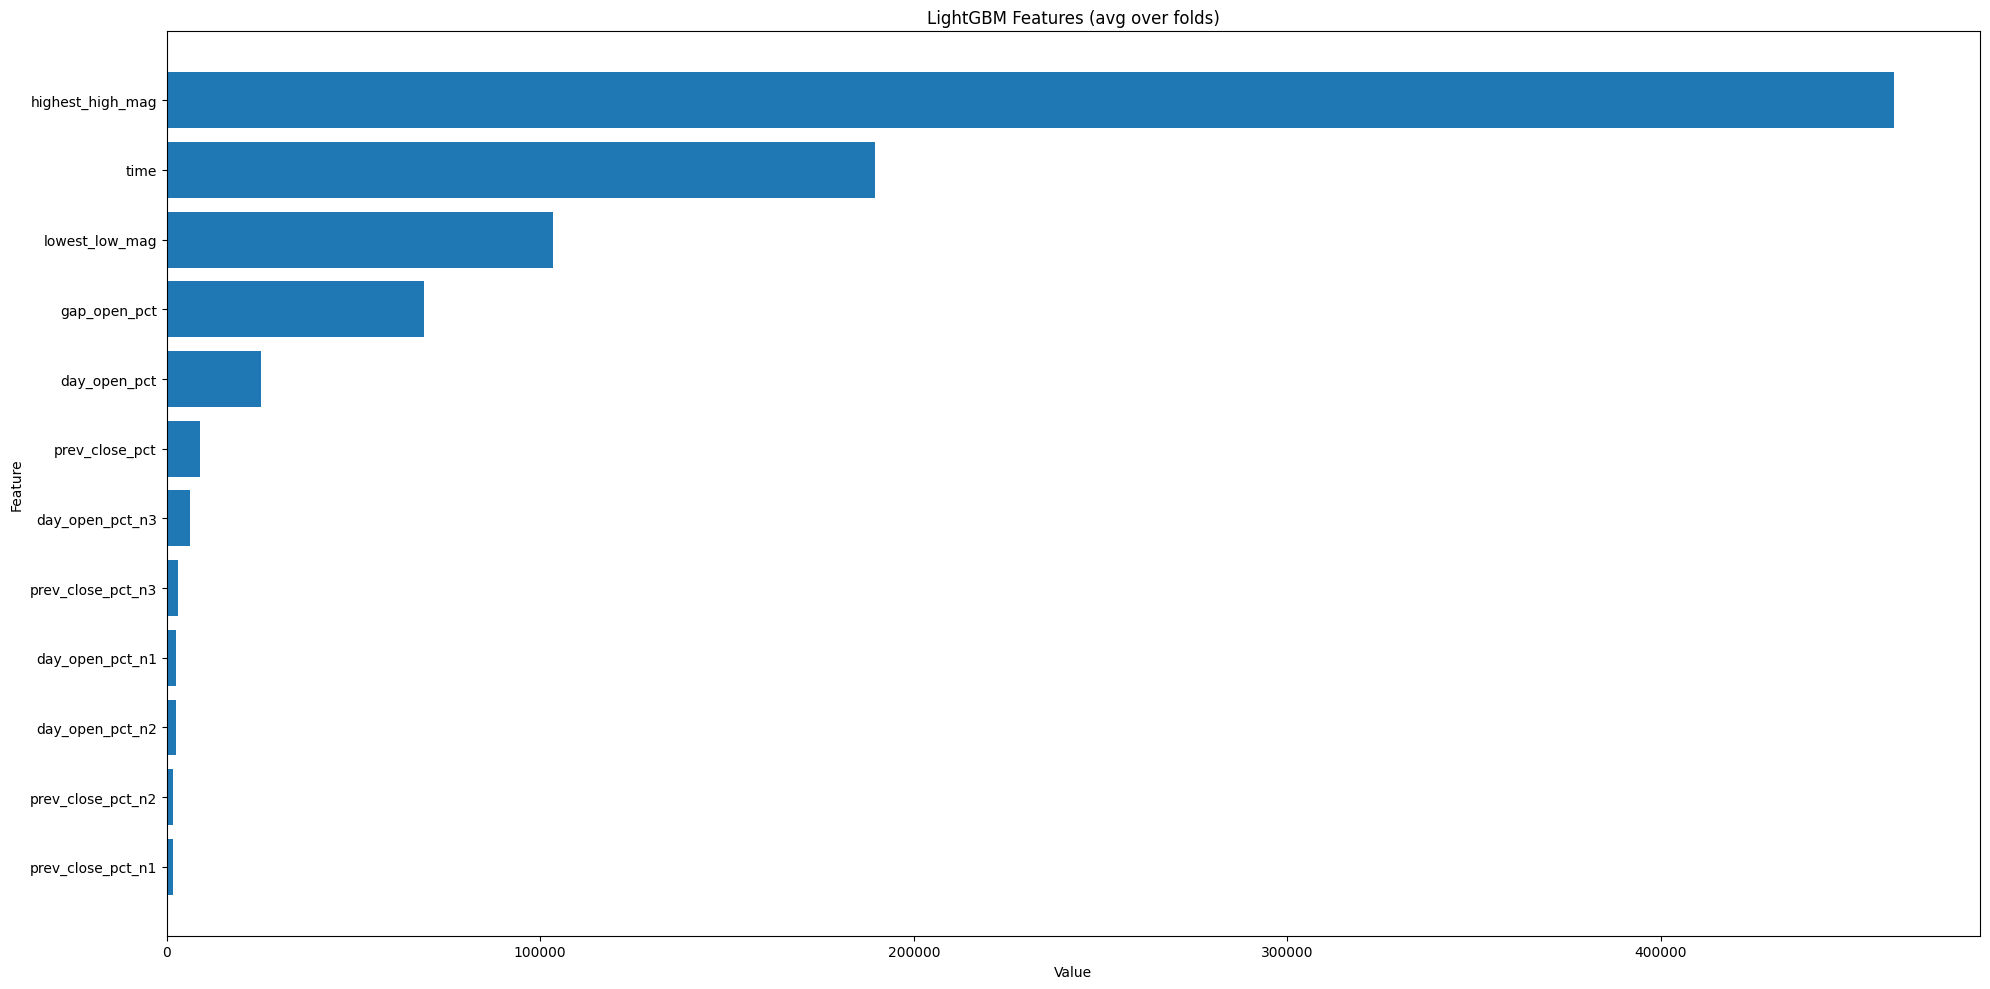

In [200]:
import mlflow
import matplotlib.pyplot as plt

booster = hod_model.named_steps['classifier'].booster_
importance_gain = booster.feature_importance(importance_type='gain')
feature_imp = pd.DataFrame(sorted(zip(importance_gain, X.columns)), columns=['Value','Feature'])
feature_imp = feature_imp.sort_values(by="Value", ascending=True)

plt.figure(figsize=(20, 10))
plt.barh(feature_imp['Feature'], feature_imp['Value'])
plt.title('LightGBM Features (avg over folds)')
plt.xlabel('Value')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


In [201]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score
import mlflow

# Metrics for HOD model
y_pred_hod = hod_model.predict_proba(X_test)[:,-1]

roc_auc_hod = roc_auc_score(y_test['hod_in'], y_pred_hod)
precision_hod = precision_score(y_test['hod_in'], y_pred_hod > 0.5)
recall_hod = recall_score(y_test['hod_in'], y_pred_hod > 0.5)

print(f"ROC AUC Score: {roc_auc_hod}")
print(f"Precision Score: {precision_hod}")
print(f"Recall Score: {recall_hod}")

train_start = X_train.index.date.min()
train_end = X_train.index.date.max()
test_start = X_test.index.date.min()
test_end = X_test.index.date.max()
train_size = len(X_train)
test_size = len(X_test)

# Start a new MLFlow run
with mlflow.start_run():

    ts = datetime.datetime.now()

    mlflow.set_tag(f"mlflow.runName", f"{tck} HOD Model {ts.hour:02}:{ts.minute:02}:{ts.second:02}")

    # Log the model
    mlflow.log_param("model", str(hod_model.named_steps))

    # Log the features
    mlflow.log_param("features", hod_model.feature_names_in_)
    mlflow.log_param("train_date_range", f"{train_start} to {train_end}")
    mlflow.log_param("test_date_range", f"{test_start} to {test_end}")
    mlflow.log_param("train_size", train_size)
    mlflow.log_param("test_size", test_size)

    # Assume y_test and y_pred are your test labels and model predictions
    # Calculate scores

    # Log the scores
    mlflow.log_metric("roc_auc", roc_auc_hod)
    mlflow.log_metric("precision", precision_hod)
    mlflow.log_metric("recall", recall_hod)

    # Log the timestamp
    mlflow.log_param("created_at", ts)

print('done.')

ROC AUC Score: 0.8797447992120617
Precision Score: 0.8121632946246857
Recall Score: 0.8096431555078172
done.


In [202]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score

# Metrics for LOD model
y_pred_lod = lod_model.predict_proba(X_test)[:,-1]

roc_auc_lod = roc_auc_score(y_test['lod_in'], y_pred_lod)
precision_lod = precision_score(y_test['lod_in'], y_pred_lod > 0.5)
recall_lod = recall_score(y_test['lod_in'], y_pred_lod > 0.5)

print(f"ROC AUC Score: {roc_auc_lod}")
print(f"Precision Score: {precision_lod}")
print(f"Recall Score: {recall_lod}")

# Start a new MLFlow run
with mlflow.start_run():

    ts = datetime.datetime.now()

    mlflow.set_tag(f"mlflow.runName", f"{tck} LOD Model {ts.hour:02}:{ts.minute:02}:{ts.second:02}")

    # Log the model
    mlflow.log_param("model", str(lod_model.named_steps))

    # Log the features
    mlflow.log_param("features", lod_model.feature_names_in_)
    mlflow.log_param("train_date_range", f"{train_start} to {train_end}")
    mlflow.log_param("test_date_range", f"{test_start} to {test_end}")
    mlflow.log_param("train_size", train_size)
    mlflow.log_param("test_size", test_size)

    # Assume y_test and y_pred are your test labels and model predictions
    # Calculate scores

    # Log the scores
    mlflow.log_metric("roc_auc", roc_auc_lod)
    mlflow.log_metric("precision", precision_lod)
    mlflow.log_metric("recall", recall_lod)

    # Log the timestamp
    mlflow.log_param("created_at", ts)

print('done.')

ROC AUC Score: 0.8582773873679408
Precision Score: 0.7916748865653975
Recall Score: 0.8503019387646996
done.


In [203]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score

# Metrics for LOD model
y_pred_gd = gd_model.predict_proba(X_test)[:,-1]

roc_auc_gd = roc_auc_score(y_test['green_day'], y_pred_gd)
precision_gd = precision_score(y_test['green_day'], y_pred_gd > 0.5)
recall_gd = recall_score(y_test['green_day'], y_pred_gd > 0.5)

print(f"ROC AUC Score: {roc_auc_gd}")
print(f"Precision Score: {precision_gd}")
print(f"Recall Score: {recall_gd}")

# Start a new MLFlow run
with mlflow.start_run():

    ts = datetime.datetime.now()

    mlflow.set_tag(f"mlflow.runName", f"{tck} GD Model {ts.hour:02}:{ts.minute:02}:{ts.second:02}")

    # Log the model
    mlflow.log_param("model", str(gd_model.named_steps))

    # Log the features
    mlflow.log_param("features", gd_model.feature_names_in_)
    mlflow.log_param("train_date_range", f"{train_start} to {train_end}")
    mlflow.log_param("test_date_range", f"{test_start} to {test_end}")
    mlflow.log_param("train_size", train_size)
    mlflow.log_param("test_size", test_size)

    # Assume y_test and y_pred are your test labels and model predictions
    # Calculate scores

    # Log the scores
    mlflow.log_metric("roc_auc", roc_auc_gd)
    mlflow.log_metric("precision", precision_gd)
    mlflow.log_metric("recall", recall_gd)

    # Log the timestamp
    mlflow.log_param("created_at", ts)

print('done.')

ROC AUC Score: 0.9044964534684206
Precision Score: 0.841897233201581
Recall Score: 0.834265890778872
done.


In [204]:
# feature_names = pipeline.feature_names_in_
# coefficients = pipeline.named_steps['classifier'].feature_importances_
# # coefficients = pipeline.named_steps['classifier'].coef_[0]
# for feature, coef in zip(feature_names, coefficients):
#     print(f"{feature}: {coef}")

In [205]:
import datetime
import plotly.express as px


time_range = [datetime.time(hour, minute) for hour in range(9, 16) for minute in range(0, 60, 5)]
time_range = [x for x in time_range if x >= datetime.time(9,45)]
df_val = pd.DataFrame()
for t in time_range:
    X_val = X_test.loc[X_test['time'] <= t].copy()
    y_val = y_test.loc[X_val.index, 'hod_in'].copy()

    y_pred_val = pipeline.predict_proba(X_val)[:,-1]

    df_val.loc[t, [
        'roc_auc',
        'precision',
        'recall'
    ]] =  roc_auc_score(y_val, y_pred_val), precision_score(y_val, y_pred_val > 0.5), recall_score(y_val, y_pred_val > 0.5)


fig = px.line(df_val, title='Validation Metrics Over Time (HOD Model)')
fig.show()

In [206]:
import datetime
import plotly.express as px

time_range = [datetime.time(hour, minute) for hour in range(9, 16) for minute in range(0, 60, 5)]
time_range = [x for x in time_range if x >= datetime.time(9,45)]
df_val = pd.DataFrame()
for t in time_range:
    X_val = X_test.loc[X_test['time'] <= t].copy()
    y_val = y_test.loc[X_val.index, 'lod_in'].copy()

    y_pred_val = pipeline_lod.predict_proba(X_val)[:,-1]

    df_val.loc[t, [
        'roc_auc',
        'precision',
        'recall'
    ]] =  roc_auc_score(y_val, y_pred_val), precision_score(y_val, y_pred_val > 0.5), recall_score(y_val, y_pred_val > 0.5)


fig = px.line(df_val, title='Validation Metrics Over Time (LOD Model)')
fig.show()

In [207]:
import datetime
import plotly.express as px

time_range = [datetime.time(hour, minute) for hour in range(9, 16) for minute in range(0, 60, 5)]
time_range = [x for x in time_range if x >= datetime.time(9,45)]
df_val = pd.DataFrame()
for t in time_range:
    X_val = X_test.loc[X_test['time'] <= t].copy()
    y_val = y_test.loc[X_val.index, 'green_day'].copy()

    y_pred_val = pipeline_gd.predict_proba(X_val)[:,-1]

    df_val.loc[t, [
        'roc_auc',
        'precision',
        'recall'
    ]] =  roc_auc_score(y_val, y_pred_val), precision_score(y_val, y_pred_val > 0.5), recall_score(y_val, y_pred_val > 0.5)


fig = px.line(df_val, title='Validation Metrics Over Time (GD Model)')
fig.show()

In [208]:
df_results = X_test.copy()
df_results['pred_hod'] = y_pred_hod
df_results['pred_lod'] = y_pred_lod
df_results['pred_gd'] = y_pred_gd

In [209]:
X_test.index[0]

Timestamp('2023-03-02 09:45:00')

In [213]:
import plotly.graph_objects as go

# Pick a day in the test set
test_day = '2023-12-21'
# test_day = '2023-12-26'
test_df = df_results.loc[test_day:test_day]
X_prices = spx_data.loc[test_day:test_day, ['open','high','low','close']]

df_viz = test_df.merge(X_prices, left_index=True, right_index=True)

fig = go.Figure(data=[go.Candlestick(x=df_viz.index,
                open=df_viz['open'],
                high=df_viz['high'],
                low=df_viz['low'],
                close=df_viz['close'])])

fig.add_trace(go.Scatter(x=df_viz.index, y=df_viz['pred_hod'].ewm(3).mean(), mode='lines', name='pred_hod', yaxis='y2', line=dict(color='#ff5f5f')))
fig.add_trace(go.Scatter(x=df_viz.index, y=df_viz['pred_lod'].ewm(3).mean(), mode='lines', name='pred_lod', yaxis='y2', line=dict(color='#3399cc')))
fig.add_trace(go.Scatter(x=df_viz.index, y=df_viz['pred_gd'].ewm(3).mean(), mode='lines', name='pred_lod', yaxis='y2', line=dict(color='#98ff98')))

fig.add_shape(
    type="line",
    x0=df_viz.index.min(),
    x1=df_viz.index.max(),
    y0=0.5,
    y1=0.5,
    yref='y2',
    line=dict(
        color="Red",
        width=1.5,
        dash="dash",
    )
)

fig.update_layout(
    template='plotly_dark',
    yaxis=dict(
        tickformat='.0f'
    ),
    yaxis2=dict(
        overlaying='y',
        side='right',
        tickformat=".0%"
    ),
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    ),
    title='OHLC vs Prediction Over Time',
    xaxis_rangeslider_visible=False
)

fig.show()

In [211]:
XXX

NameError: name 'XXX' is not defined

# Inference Pipeline

In [ ]:
# Get data
import yfinance as yf
import numpy as np
import pandas as pd
import datetime

def create_features(ticker_str):
    '''
    Function to create dataframe of features for top/bottom model.
    '''
    ticker = yf.Ticker(ticker_str)
    df = ticker.history(period='5d',interval='5m')
    df = df.loc[
        (df.index.time >= datetime.time(9,45)) &\
        (df.index.time < datetime.time(16,0)),
    ['Open','High','Low','Close']]
    df.columns = ['open','high','low','close']

    df['time'] = df.index.time
    df['eod_close'] = df.groupby(df.index.date)['close'].tail(1)
    df['prev_close'] = df['eod_close'].shift(1)
    df['prev_close'] = df['prev_close'].ffill()
    df['eod_close'] = df['eod_close'].bfill()
    df['green_day'] = df['eod_close'] > df['prev_close']

    df['eod_close_pts'] = df['eod_close'] - df['prev_close']
    df['eod_close_pct'] = df['eod_close_pts'] / df['prev_close']

    for day in sorted(set(df.index.date)):
        day_str = datetime.datetime.strftime(day, '%Y-%m-%d')
        day_open = df.loc[day_str, 'open'].iloc[0]
        df.loc[day_str, 'lod'] = df.loc[day_str, 'low'].min()
        df.loc[day_str, 'label_lod'] = (df.loc[day_str, 'low'] == df.loc[day_str, 'lod']).astype(int)
        
        df.loc[day_str, 'hod'] = df.loc[day_str, 'high'].max()
        df.loc[day_str, 'label'] = (df.loc[day_str, 'high'] == df.loc[day_str, 'hod']).astype(int)
        df.loc[day_str, 'day_open'] = day_open
        df.loc[day_str, 'day_open_pts'] = df.loc[day_str, 'close'] - df.loc[day_str, 'day_open']
        df.loc[day_str, 'day_open_pct'] = df.loc[day_str, 'day_open_pts'] / df.loc[day_str, 'day_open']
        df.loc[day_str, 'prev_close_pts'] = df.loc[day_str, 'close'] - df.loc[day_str, 'prev_close']
        df.loc[day_str, 'prev_close_pct'] = df.loc[day_str, 'prev_close_pts'] / df.loc[day_str, 'prev_close']

        # Lowest low
        df.loc[day_str, 'lowest_low'] = df.loc[day_str, 'low'].expanding().min()
        df.loc[day_str, 'lowest_low'] = df.loc[day_str, 'lowest_low'].shift(1)
        df.loc[day_str, 'lowest_low'] = df.loc[day_str, 'lowest_low'].ffill()
        df.loc[day_str, 'lowest_low_mag'] = (df.loc[day_str, 'close'] / df.loc[day_str, 'lowest_low']) - 1

        # Highest high
        df.loc[day_str, 'highest_high'] = df.loc[day_str, 'high'].expanding().max()
        df.loc[day_str, 'highest_high'] = df.loc[day_str, 'highest_high'].shift(1)
        df.loc[day_str, 'highest_high'] = df.loc[day_str, 'highest_high'].ffill()
        df.loc[day_str, 'highest_high_mag'] = (df.loc[day_str, 'close'] / df.loc[day_str, 'highest_high']) - 1

        # Shifted
        df.loc[day_str, 'prev_close_pct_n1'] = df.loc[day_str, 'prev_close_pct'].shift(1)
        df.loc[day_str, 'prev_close_pct_n2'] = df.loc[day_str, 'prev_close_pct'].shift(2)
        df.loc[day_str, 'prev_close_pct_n3'] = df.loc[day_str, 'prev_close_pct'].shift(3)

        df.loc[day_str, 'day_open_pct_n1'] = df.loc[day_str, 'day_open_pct'].shift(1)
        df.loc[day_str, 'day_open_pct_n2'] = df.loc[day_str, 'day_open_pct'].shift(2)
        df.loc[day_str, 'day_open_pct_n3'] = df.loc[day_str, 'day_open_pct'].shift(3)

    df['gap_open'] = df['day_open'] - df['prev_close']
    df['gap_open_pct'] = df['gap_open'] / df['prev_close']
    return df.dropna(subset=[
        'prev_close_pct',
        'gap_open_pct',
        'day_open_pct_n3',
        'prev_close_pct_n3'
    ])

In [ ]:
import joblib

df_feats = create_features(tck)

In [ ]:

hod_model1 = joblib.load(ticker_dict[tck]['hod_model'])
lod_model1 = joblib.load(ticker_dict[tck]['lod_model'])
gd_model1 = joblib.load(ticker_dict[tck]['gd_model'])

def create_preds_df(df_feats):
    predicted_proba_hod = hod_model1.predict_proba(df_feats)[:,-1]
    predicted_proba_lod = lod_model1.predict_proba(df_feats)[:,-1]
    predicted_proba_gd = gd_model1.predict_proba(df_feats)[:,-1]
    df_viz = df_feats.copy()
    df_viz['pred_hod'] = predicted_proba_hod
    df_viz['pred_lod'] = predicted_proba_lod
    df_viz['pred_gd'] = predicted_proba_gd
    return df_viz

df_viz = create_preds_df(df_feats)

In [ ]:
# Create df for visual
def create_viz(df_viz, date_str):

    df_use = df_viz.loc[date_str:date_str]
    
    fig = go.Figure(data=[go.Candlestick(x=df_use.index,
                open=df_use['open'],
                high=df_use['high'],
                low=df_use['low'],
                close=df_use['close'])])

    fig.add_trace(go.Scatter(x=df_use.index, y=df_use['pred_hod'], mode='lines', name='pred_hod', yaxis='y2', line=dict(color='#ff5f5f')))
    fig.add_trace(go.Scatter(x=df_use.index, y=df_use['pred_lod'], mode='lines', name='pred_lod', yaxis='y2', line=dict(color='#3399cc')))
    fig.add_trace(go.Scatter(x=df_use.index, y=df_use['pred_gd'], mode='lines', name='pred_gd', yaxis='y2', line=dict(color='#9400d3')))


    fig.add_shape(
        type="line",
        x0=df_use.index.min(),
        x1=df_use.index.max(),
        y0=0.5,
        y1=0.5,
        yref='y2',
        line=dict(
            color="Red",
            width=1.5,
            dash="dash",
        )
    )

    max_high = df_use['high'].max()
    max_high_time = df_use['high'].idxmax()

    min_low = df_use['low'].min()
    min_low_time = df_use['low'].idxmin()

    fig.add_annotation(
        x=max_high_time,
        y=max_high,
        text=f"{str(int(max_high))}",
        showarrow=True,
        font=dict(
            family="Courier New, monospace",
            size=12,
            color="#ffffff"
        ),
        align="center",
        arrowhead=2,
        arrowsize=1,
        arrowwidth=2,
        arrowcolor="#636363",
        ax=20,
        ay=-30,
        bordercolor="#c7c7c7",
        borderwidth=1,
        borderpad=1,
        bgcolor="#ff5f5f",
        opacity=0.8
    )

    fig.add_annotation(
        x=min_low_time,
        y=min_low,
        text=f"{str(int(min_low))}",
        showarrow=True,
        font=dict(
            family="Courier New, monospace",
            size=12,
            color="#ffffff"
        ),
        align="center",
        arrowhead=2,
        arrowsize=1,
        arrowwidth=2,
        arrowcolor="#636363",
        ax=20,
        ay=30,  # Adjust the y offset for the annotation
        bordercolor="#c7c7c7",
        borderwidth=1,
        borderpad=1,
        bgcolor="#3399cc",
        opacity=0.8
    )

    fig.update_layout(
        template='plotly_dark',
        yaxis=dict(
            tickformat='.0f'
        ),
        yaxis2=dict(
            overlaying='y',
            side='right',
            tickformat=".0%"
        ),
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="right",
            x=1
        ),
        title='OHLC vs Prediction Over Time',
        xaxis_rangeslider_visible=False
    )

    fig.show()
    

In [ ]:
create_viz(df_viz, '2024-01-02')

In [ ]:
XXX

In [ ]:
time_value = datetime.time(13,0)
prev_close_pct = 0.005
day_open_pct = 0.00
gap_open_pct = -0.005

input_data = pd.DataFrame({
    'time': [time_value], 
    'prev_close_pct': [prev_close_pct],
    'day_open_pct': [day_open_pct],
    'gap_open_pct': [gap_open_pct],
    })
predicted_proba = pipeline.predict_proba(input_data)[:,-1]

print(f"Predicted Probability: {predicted_proba[0]}")

In [ ]:
get_top_probability(time_value, prev_close_pct)

In [ ]:
XXX

In [ ]:
daily_data = spx_data.groupby(spx_data.index.date)['eod_close_pct'].max()

In [ ]:
daily_data.describe()

In [ ]:
daily_data.clip(-0.05,0.05).hist()

In [ ]:
spx_data.loc[(spx_data['time'] < datetime.time(10,5)) & (spx_data['label'] == 1), 'prev_close_pct'].describe()

In [ ]:
len(set(spx_data.index.date))

In [ ]:
import plotly.graph_objects as go

# df_use = spx_data.query('(eod_close_pct > -0.007) & (eod_close_pct < 0.007)')
df_use = spx_data.query('(eod_close_pct < 0.01) & (eod_close_pct > -0.01)')
# df_use = spx_data.copy()
total_days = len(set(spx_data.index.date))
set_days = len(set(df_use.index.date))
# Convert times to string
times = df_use['time'].unique()
times = [t.strftime('%H:%M:%S') for t in times]
freqs = df_use.groupby('time')['label'].mean().cumsum()

# Calculate means
means = df_use.groupby('time')['prev_close_pct'].mean()

# Create a Plotly figure
fig = go.Figure()

# Add a line trace
fig.add_trace(go.Scatter(x=times, y=means, mode='lines', name='Mean'))

fig.add_trace(go.Scatter(x=times, y=freqs, mode='lines', name='Frequency', yaxis='y2'))
fig.update_layout(
    yaxis2=dict(
        title='Frequency',
        titlefont=dict(
            color='rgb(148, 103, 189)'
        ),
        tickfont=dict(
            color='rgb(148, 103, 189)'
        ),
        overlaying='y',
        side='right'
    )
)
fig.update_yaxes(
    tickformat=".3%",
)

# Set layout properties
fig.update_layout(
    title=f'Mean vs Time ({str(set_days)} -- {set_days / total_days:.1%})',
    xaxis_title='Time',
    yaxis_title='Mean',
    autosize=False,
    width=1000,
    height=500,
)

# Show the figure
fig.show()

In [ ]:
import numpy as np
import pandas as pd
import datetime

spx_data['label_lod'] = np.nan

# Per date, run it.
for day in sorted(set(spx_data.index.date)):
    day_str = datetime.datetime.strftime(day, '%Y-%m-%d')
    spx_data.loc[day_str, 'lod'] = spx_data.loc[day_str, 'low'].min()

    # Label the data: 1 if the current low is the LOD, 0 otherwise
    spx_data.loc[day_str, 'label_lod'] = (spx_data.loc[day_str, 'low'] == spx_data.loc[day_str, 'lod']).astype(int)

    # Find the index of LOD
    lod_index = spx_data.loc[day_str][spx_data.loc[day_str, 'label_lod'] == 1].index

    # If LOD is found within the first 5 bars, label the first 5 bars as 1
    if not lod_index.empty:
        lod_index = lod_index[0]  # In case there are multiple, take the first
        if lod_index <= spx_data.loc[day_str].index[4]:  # Check if LOD is within the first 5 bars
            spx_data.loc[spx_data.loc[day_str].index[:5], 'label_lod'] = 1
        else:
            start_time = spx_data.loc[day_str].index[0]
            end_time = lod_index
            # Calculate the start index using Timedelta
            start_index = end_time - pd.Timedelta(minutes=5 * 4)
            start_index = max(start_index, start_time)
            spx_data.loc[start_index:end_time, 'label_lod'] = 1

spx_data.head()

In [ ]:
spx_data['time'] = spx_data.index.time

In [ ]:
spx_data['label'].sum()

In [ ]:
pd.spx_data.groupby('time')['label'].mean()

In [ ]:
import matplotlib.pyplot as plt
d = '2023-12-20'
spx_data.loc[d,'label'].plot();
spx_data.loc[d,'label_lod'].plot();
plt.legend();
print(spx_data.loc[d,'label_lod'].sum())

In [ ]:
spx_data['label'].value_counts()

In [ ]:
len(set(spx_data.index.date))

In [ ]:
spx_data.loc[day]

In [ ]:
import pandas as pd

# Load data
# data = pd.read_csv('your_data_file.csv', parse_dates=True)

# Calculate P as the average of open, high, low, and close
spx_data['P'] = spx_data[['open', 'high', 'low', 'close']].mean(axis=1)

# Initialize columns for ON, O1, O2, O3
spx_data['ON'] = spx_data['P'].rolling(window=6).max()
spx_data['O1'] = spx_data['P'].rolling(window=6).apply(lambda x: x.nsmallest(2).iloc[0] if x.idxmax() != x.index[-1] else x.nsmallest(2).iloc[1])
spx_data['O2'] = spx_data['P'].rolling(window=6).apply(lambda x: x.nsmallest(3).iloc[1] if x.idxmax() == x.index[-2] else (x.nsmallest(3).iloc[0] if x.idxmax() != x.index[-1] else x.nsmallest(3).iloc[2]))
spx_data['O3'] = spx_data['P'].rolling(window=6).apply(lambda x: x.nsmallest(3).iloc[2])

# Set iMA (fast_ma)
spx_data['fast_ma'] = spx_data['O3']


In [ ]:

# Display the result
spx_data[['Datetime','P', 'ON', 'O1', 'O2', 'O3', 'fast_ma']].tail()


In [ ]:
# Initializing the required columns
spx_data['a'] = 0
spx_data['b'] = 0
spx_data['z'] = 0
spx_data['c'] = 0
spx_data['l'] = 0
spx_data['s'] = 0

# Helper functions to calculate lowest_low, highest_high, avg_low, avg_high
spx_data['lowest_low'] = spx_data['low'].rolling(window=5).min()
spx_data['highest_high'] = spx_data['high'].rolling(window=5).max()
spx_data['avg_low'] = spx_data['low'].rolling(window=5).mean()
spx_data['avg_high'] = spx_data['high'].rolling(window=5).mean()

for i, row in spx_data.iterrows():
    if i == 0:
        continue  # Skip the first row

    a_prev = spx_data.at[i - 1, 'a']
    low_prev = spx_data.at[i - 1, 'low']
    high_prev = spx_data.at[i - 1, 'high']

    if a_prev == 1:
        spx_data.at[i, 'b'] = max(spx_data.at[i, 'lowest_low'], spx_data.at[i - 1, 'b'])
        spx_data.at[i, 'z'] = 1 if spx_data.at[i, 'avg_high'] < spx_data.at[i - 1, 'b'] and spx_data.at[i, 'close'] < low_prev else spx_data.at[i - 1, 'z']
        spx_data.at[i, 'a'] = 0 if spx_data.at[i, 'avg_high'] < spx_data.at[i - 1, 'b'] and spx_data.at[i, 'close'] < low_prev else a_prev
        spx_data.at[i, 'c'] = spx_data.at[i, 'highest_high'] if spx_data.at[i, 'avg_high'] < spx_data.at[i - 1, 'b'] and spx_data.at[i, 'close'] < low_prev else spx_data.at[i - 1, 'c']
    elif a_prev == 0:
        spx_data.at[i, 'c'] = min(spx_data.at[i, 'highest_high'], spx_data.at[i - 1, 'c'])
        spx_data.at[i, 'z'] = 0 if spx_data.at[i, 'avg_low'] > spx_data.at[i - 1, 'c'] and spx_data.at[i, 'close'] > high_prev else spx_data.at[i - 1, 'z']
        spx_data.at[i, 'a'] = 1 if spx_data.at[i, 'avg_low'] > spx_data.at[i - 1, 'c'] and spx_data.at[i, 'close'] > high_prev else a_prev
        spx_data.at[i, 'b'] = spx_data.at[i, 'lowest_low'] if spx_data.at[i, 'avg_low'] > spx_data.at[i - 1, 'c'] and spx_data.at[i, 'close'] > high_prev else spx_data.at[i - 1, 'b']
    else:
        # Maintain the previous values
        spx_data.at[i, 'b'] = spx_data.at[i - 1, 'b']
        spx_data.at[i, 'z'] = spx_data.at[i - 1, 'z']
        spx_data.at[i, 'a'] = a_prev
        spx_data.at[i, 'c'] = spx_data.at[i - 1, 'c']

    # Adjusting 'l' and 's'
    if spx_data.at[i, 'z'] == 0:
        spx_data.at[i, 'l'] = spx_data.at[i - 1, 's'] if spx_data.at[i - 1, 'z'] != 0 else max(spx_data.at[i - 1, 'b'], spx_data.at[i - 1, 'l'])
        spx_data.at[i, 's'] = 0
    elif spx_data.at[i - 1, 'z'] != 1:
        spx_data.at[i, 's'] = spx_data.at[i - 1, 'l']
        spx_data.at[i, 'l'] = 0
    elif spx_data.at[i, 'z'] == 1:
        spx_data.at[i, 's'] = min(spx_data.at[i, 'c'], spx_data.at[i - 1, 's'])
        spx_data.at[i, 'l'] = spx_data.at[i - 1, 'l']
    else:
        spx_data.at[i, 'l'] = spx_data.at[i - 1, 'l']
        spx_data.at[i, 's'] = spx_data.at[i - 1, 's']

    # Setting 'trail'
    spx_data.at[i, 'trail'] = spx_data.at[i, 'l'] if spx_data.at[i, 'l'] > 0 else spx_data.at[i, 's']

# # Display the result
# print(spx_data[['a', 'b', 'z', 'c', 'l', 's', 'trail']])


In [ ]:
spx_data[['close', 'fast_ma']].tail().plot()

# Backtesting

In [ ]:
import bt
import pandas as pd

# Load your data
# data = pd.read_csv('your_data_file.csv', index_col='Date', parse_dates=True)

# Custom Algo for selecting where to trade
class SelectWhere(bt.Algo):
    def __init__(self, signal):
        self.signal = signal

    def __call__(self, target):
        if target.now in self.signal.index:
            signal_value = self.signal.loc[target.now]
            target.temp['weights'] = signal_value.astype(float)
        return True

# Create the signal for the strategy
signal = (data['close'] > data['fast_ma']) & (data['close'].shift() < data['slow_ma'])

# Create the strategy
strategy = bt.Strategy('AboveFastMA',
                       [SelectWhere(signal),
                        bt.algos.WeighTarget('weights'),
                        bt.algos.Rebalance()])

# Create a backtest and run it
test = bt.Backtest(strategy, data)

# Set up the backtest with transaction costs and slippage
commissions = bt.fees.FixedPerTrade(1) # $1 per trade
slippage = bt.slippage.FixedSlippage(0.05) # Fixed slippage per share, adjust as needed

# Set the commissions and slippage to the backtest
test.set_fees(commissions=commissions, slippage=slippage)

# Run the backtest
res = bt.run(test)

# Plot the results
res.plot()
